In [1]:
# Python core Libraries
import sys
import os
import random as rnd
from os import listdir
from os.path import isfile, isdir, join
# Fundamental Libraries for Machine Learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import glob   # In order to get images as matrices from directory

# Scikit-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Traditional Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from sklearn.neighbors import KNeighborsClassifier # K Nearest Neighbor Classifier Algorithm
from sklearn.naive_bayes import GaussianNB # Naive Bayes Classifier
from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier 
# Classification Evaluation metrics and Visualization
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Evaluation metrics
from sklearn.metrics import classification_report  # Precision, recall, f1-score metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Classifier Confusion Matrix visualization
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# Tensorflow Libraries for Deep Neural Networks
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy

In [2]:
BATCH_SIZE = 32      # Number of batches for each epoch (common used batch size 32 is not suitable for out data)
NUM_EPOCH = 100        # How many epoch will be used for model training
IMG_SIZE = (90,90)    # Input Image size
INPUT_SIZE = (90, 90, 3) # RGB format Image
CONT_MARGIN = 1       # Contrastive Loss margin
K_FOLD_VALID = 10     # K for cross validation
RND_STATE = 24        # Randomness constant for robust outputs
DATA_AUG = False       # Apply Data augmentation 

# Dataset Directory
DATASET_DIR           = '/kaggle/input/mvtec-transistor-dataset/transistor/'
# DATASET_DIR           = '/kaggle/input/screwanomalies-detection/screw/'
DATA_TRAIN_POS_DIR    = DATASET_DIR + 'train/good/'
DATA_TEST_POS_DIR     = DATASET_DIR + 'test/good'
DATA_TEST_DIR         = DATASET_DIR + 'test/'
# Training and Testing Negative data will be gathering from test directory

In [3]:
# Each training and test example is assigned to one of the following labels:
labels = ["defect", "defect-free"]

In [4]:
class VisionBasics():
    def __init__(self) -> None:
        self.files = []
        self.formats = ['jpg', 'png', 'jpeg']  # Add valid image formats here
        self._project_directory()
        pass

    def _project_directory(self):
        if (str(sys.platform) == "darwin") or (str(sys.platform) == "linux"):    # MacOS or Linux Environment
            current_dir = os.getcwd() + "/"
        else:   # Windows Environment
            current_dir = os.getcwd() + "\\"
        self.files = os.listdir(current_dir)

    def get_files(self):
        return self.files

    def print_files_of_project_directory(self):
        print(self.files)

    def save_ml_model(self, model, tag='Model'):
        pickle.dump(model, open(tag, 'wb'))

    def load_ml_model(self, directory):
        return pickle.load(open(directory, 'rb'))

    # Example of usage change_img_file_format method:
    # change_img_file_format.open(r'C:\Users\Ron\Desktop\Test\summer.png', )
    # TODO: Continue to write this method
    def change_img_file_format(self, img_dir, src_format, dest_format):
        cnv_rgx_frmt = lambda frmt: '\.' + frmt + '$' 
        rgx_formats = map(cnv_rgx_frmt, self.formats)

        if any([(re.search(format, img_dir)!=None) for format in rgx_formats]):
            if dest_format in self.formats:
                if dest_format in img_dir[-5:]:
                    print("UserWarning: This image file is already {0} format".format(dest_format))
                else:
                    img = Image.open(img_dir)
                    img.save()
            else:
                raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")    
        else:
            raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")

    ''' DEEP LEARNING METHODS FOR COMPUTER VISION '''
    # Load the specified file as a tf.image and preprocess it (see valid image formats)
    # See tf.keras.preprocessing.image_dataset_from_directory (https://keras.io/api/preprocessing/image/)
    def get_imgs_from_directory_as_numpy_array(self, dir, ext, size=None, scl=None, version=2):
        if ext in self.formats:
            rgx_for_img = dir + "/*." + ext
            img_list = glob.glob(rgx_for_img)

            # Scale image
            # scl_img = lambda img: ((img.astype('float32'))/255.0)

            if version < 0:
                # Function V0.1 (Use version 1 if any incompatibility on CUDA GPU version and the tf)
                # Cleanup called error on virtual machine
                if size is None:
                    img_arr = np.array([np.array(Image.open(img)) for img in img_list])
                else:
                    img_arr = np.array([np.array(Image.open(img).resize(size)) for img in img_list])

                img_arr = img_arr.astype('float32')
                if scl == '8bit': img_arr /= 255.0
                    
                return img_arr
            elif version == 1:
                def process_images(filename):
                    img = keras.preprocessing.image.load_img(filename, color_mode="rgb", target_size=size)
                    img_arr = keras.preprocessing.image.img_to_array(img)
                    img_arr = np.array(img_arr).astype('float32')  
                    if scl == '8bit': img_arr /= 255.0
                    return img_arr
                
                return np.array(list(map(process_images, img_list)))
                # https://keras.io/api/preprocessing/image/
                # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
            else:
                def process_images(filename):
                    image_string = tf.io.read_file(filename)
                    # Decode a JPEG-encoded image to a uint8 tensor
                    # image = tf.image.decode_image(image_string, channels=3)  
                    image = tf.image.decode_image(image_string, channels=0)    
                    # channels: An optional int. Defaults to 0. Number of color channels for the decoded image
                    # Detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert 
                    # the input bytes string into a Tensor of type dtype.
                    image = tf.image.convert_image_dtype(image, tf.float32)
                    image = image.numpy()
                    if size != None:
                        image = tf.image.resize(image, size)
                    if scl == '8bit':
                        image /= 255.0
                    return image

                return list(map(process_images, img_list))
        else:
            raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")

    # This method prepares a data array as a keras input
    # Example of input_size parameter usage: (28,28,1) -> 28x28 pixels gray scale images, (28,28,3) 28x28 pixels RGB images
    # Example of np_array parameter usage: np_array.shape = (60000, 28, 28) OR (60000, 784)
    def prepare_imgs_as_keras_input(self, np_array, input_size):
        w, h, d = input_size
        return np_array.reshape(np_array.shape[0], w, h, d)

    # Visualize triplets from the batches
    def show_triplet_images(self, anchor, positive, negative, size=(10,10), row=3):
        def plot_img(ax, image):
            ax.imshow(image)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        fig = plt.figure(figsize=size)

        axs = fig.subplots(row, 3)
        for i in range(row):
            plot_img(axs[i, 0], anchor[i])
            plot_img(axs[i, 1], positive[i])
            plot_img(axs[i, 2], negative[i])

    ''' CONVENTIONAL CLASSIFICATION ALGORITHMS FOR COMPUTER VISION '''
    def get_misclassified_indexes(self, y_test, y_pred):
        missed = []
        missed = np.where(y_test[y_test != y_pred])
        return missed[0]

    # This methods prints all evaluation parameters for classification models
    def print_eval_parameters(self, model, y_test, y_pred, labels):
        print("====== " + type(model).__name__ +" model Evaluation metrics ======")
        print("Accuracy of model:      {:.3f}".format(accuracy_score(y_test, y_pred)))                    # Accuracy score: (tp + tn) / (tp + fp + tn + fn)
        print("Recall of model:        {:.3f}".format(recall_score(y_test, y_pred, average="micro")))     # Recall score: tp / (tp + fn)
        print("Precision of model:     {:.3f}".format(precision_score(y_test, y_pred, average="micro")))  # Precision score: tp / (tp + fp)
        print("F1 score of model:      {:.3f}".format(f1_score(y_test, y_pred, average="micro")))         # F1 score: 2 * (precision * recall) / (precision + recall)
        # print("Mean accuracy of the model (Score):  {:.3f}".format(model.score(X_train_valid_scl, y_train_valid)))  # Print model Mean Accuracy (score)
        print("Misclassification Number: ", (y_test != y_pred).sum())

        print("\n====== " + type(model).__name__ +" model Detailed Classification Report ======")
        # Print K Nearest Neighbor model's classification report for validation set
        # Report contains; Precision, recal and F1 score values for each label and 
        # model's accuracy, macro and weighted average
        print(classification_report(y_test, y_pred, target_names=labels))

    # This methods prints Grid Search Results for given search algorithm
    def print_grid_search_results(self, search):
        print("==== Grid Search Results ====")
        print("best_estimator: ", search.best_estimator_)
        print("best_params:    ", search.best_params_)
        print("best_score:      {:.3f}".format(search.best_score_))

    # This method plots Confusion matrix for classification models with given test dataset and prediction result array
    def show_confusion_matrix(self, y_test, y_pred, labels, w_h=(12, 7)):
        confMatrix = confusion_matrix(y_test, y_pred)
        dispConfMatrix = ConfusionMatrixDisplay(confMatrix, display_labels=labels)
        dispConfMatrix.plot()
        fig = plt.gcf()
        w, h = w_h
        fig.set_size_inches(w, h)

    # This method prints predicted and actual labels and shows actual image
    def show_prediction_result(self, x_test, y_pred, y_test, labels, n_img=None):
        # If n_img is not set, find random index between 0 and x_test length
        if n_img is None:
            n_img = rnd.randint(0, (len(x_test)- 1))
        print("====== Random Prediction Result ======")
        print("Predicted label: " + labels[y_pred[n_img]], end="")
        print("  -  Actual label: " + labels[y_test[n_img]])
        # If Predicted label and Actual label are not same there is a classification mismatch
        if labels[y_pred[n_img]] != labels[y_test[n_img]]:
            print("There is a classification mismatch here!")
        plt.title("The image of "+ labels[y_test[n_img]] +" from the Dataset")
        # plt.imshow(x_test[n_img], cmap=plt.cm.gray_r)
        plt.imshow(x_test[n_img])
        plt.show()

    def show_ROC_score(self, y_test, pos_prob, kind='fp_tp', plot=False, label='Custom Classifier'):
        if kind == 'fp_tp':   # False Positive-True Positive Curve
            auc_score = roc_auc_score(y_test, pos_prob)
            fp_rate, tp_rate, thresholds = roc_curve(y_test, pos_prob)
            plt_x, plt_y, lbl_x, lbl_y = fp_rate, tp_rate, "False Positive Rate (FP)", "True Positive Rate (TP)"
            # Generate a no skill prediction 
            noskill_probs = [0 for _ in range(len(y_test))]
            ns_auc_score = roc_auc_score(y_test, noskill_probs)
            noskill_fp_rate, noskill_tp_rate, noskill_thresholds = roc_curve(y_test, noskill_probs)

        elif kind == 'pre_rec':   # Precision-Recall Curve
            precision, recall, thresholds = precision_recall_curve(y_test, pos_prob)
            auc_score = auc(recall, precision)
            plt_x, plt_y, lbl_x, lbl_y = recall, precision, "Recall", "Precision"
        else:
            raise ValueError("Use 'fp_tp' or 'pre_rec' as kind parameter")

        print("AUC: ", auc_score)
        if kind == 'fp_tp':
            print("No-skill AUC: ", ns_auc_score)
        print("")

        if plot == True:
            plt.title("ROC Curve")
            plt.plot(plt_x, plt_y, marker='.', label=label)
            if kind == 'fp_tp':
                plt.plot(noskill_fp_rate, noskill_tp_rate, linestyle='--', label='No Skill Classifer')
            plt.xlabel(lbl_x)
            plt.ylabel(lbl_y)
            plt.legend()
            plt.show()

    def plot_randomly_img_predictions(self, img_arr, y_test, y_pred, labels, num_item=2, fig_size=[20,10]):
        plt.figure(figsize=fig_size) 
        for img in range(num_item):
            ix = rnd.randint(0, len(img_arr)-1)
            display = plt.subplot(1, num_item, img+1)

            plt.imshow(img_arr[ix], cmap="gray")
            act  = "Act: " + str(labels[(int(y_test[ix]))])
            pred = "Pred: " + str(labels[(int(y_pred[ix]))])

            plt.yticks([])
            plt.title(act)
            plt.ylabel(pred)

            display.get_xaxis().set_visible(False)
            #display.get_yaxis().set_visible(False)

        plt.show()
        
vision = VisionBasics()

In [6]:
def app_GetFolderNamesofDirectory(path):
    folders = []
    folders = [folder for folder in listdir(path) if isdir(join(path, folder))]
    return folders

In [7]:
def get_all_imgs_from_directory(directory, ext, img_arr=[], except_dir=None):
    rgx_for_img = directory + "/*." + ext
    img_list = glob.glob(rgx_for_img)
    sub_dirs = app_GetFolderNamesofDirectory(directory)
    
    # A folder can include image files and also other folders
    if len(img_list) != 0:
        img_arr.extend(img_list)
    
    if sub_dirs != 0:
        for sub_dir in sub_dirs:
            if not sub_dir in except_dir:
                img_arr = get_all_imgs_from_directory((os.path.join(directory, sub_dir)), ext, img_arr, except_dir)
    
    return img_arr

In [8]:
def plot_seq_img_pairs(img_arr, num_item, fig_size=[20,10], pair=2):
    for img_pair in range(pair):
        # Set figure size
        plt.figure(figsize=fig_size) 
        # Show each image from paired data
        for item in range(num_item):
            # rnd_img = random.randrange(0, len(img_arr)-1)
            display = plt.subplot(1, num_item, item+1)
            im = tf.keras.preprocessing.image.array_to_img(img_arr[item, img_pair], data_format=None, scale=True,dtype=None)
            plt.imshow(im, cmap="gray")
            
            act  = "" + str(item+1) + ". " + str(labels[(item)%2])
            
            plt.yticks([])
            plt.title(act)
            display.get_xaxis().set_visible(False)
            #display.get_yaxis().set_visible(False)
        plt.show()

In [9]:
def plot_randomly_img_predictions(img_arr, y_test, y_pred, num_item, fig_size=[20,10]):
    plt.figure(figsize=fig_size) 
    for img in range(num_item):
        ix = random.randint(0, len(img_arr)-1)
        display = plt.subplot(1, num_item, img+1)
        
        plt.imshow(img_arr[ix], cmap="gray")
        act  = "Act: " + str(labels[((int(y_test[ix])+1)%2)])
        pred = "Pred: " + str(labels[((int(y_pred[ix])+1)%2)])
        
        plt.yticks([])
        plt.title(act)
        plt.ylabel(pred)
        
        display.get_xaxis().set_visible(False)
        #display.get_yaxis().set_visible(False)
    
    plt.show()

In [10]:
# Data augmentation function - Returns all data (given data + augmented data)
# https://www.tensorflow.org/tutorials/images/data_augmentation
def get_augmented_data(arr, repeat=1):
    arr_list = []
    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
    ])
    
    for _ in range(repeat):
        arr_list.extend(list(map(data_augmentation, arr)))
        
    arr_list = np.concatenate((arr, arr_list), axis=0)
    
    return arr_list

In [11]:
os.listdir(DATA_TRAIN_POS_DIR)[:5]   # File format is the .png for this dataset

['173.png', '043.png', '038.png', '069.png', '083.png']

In [12]:
imgs_dirs = get_all_imgs_from_directory(directory=DATA_TEST_DIR, ext='png', except_dir=['good'])
imgs_dirs[:5]

['/kaggle/input/mvtec-transistor-dataset/transistor/test/cut_lead/007.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/cut_lead/005.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/cut_lead/004.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/cut_lead/002.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/cut_lead/000.png']

In [13]:
np.random.shuffle(imgs_dirs)
imgs_dirs[:5]

['/kaggle/input/mvtec-transistor-dataset/transistor/test/misplaced/001.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/misplaced/007.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/bent_lead/000.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/cut_lead/007.png',
 '/kaggle/input/mvtec-transistor-dataset/transistor/test/bent_lead/006.png']

In [14]:
DATA_TRAIN_POS_DIR

'/kaggle/input/mvtec-transistor-dataset/transistor/train/good/'

In [15]:
# Prepare train and test sets
x_train_ok = vision.get_imgs_from_directory_as_numpy_array(DATA_TRAIN_POS_DIR, "png", size=IMG_SIZE, scl='8bit', version=1)
x_test_ok = vision.get_imgs_from_directory_as_numpy_array(DATA_TEST_POS_DIR, "png", size=IMG_SIZE, scl='8bit', version=1)

In [16]:
print("x_train_ok.shape: ", x_train_ok.shape)
print("x_test_ok.shape: ", x_test_ok.shape)

x_train_ok.shape:  (213, 90, 90, 3)
x_test_ok.shape:  (60, 90, 90, 3)


In [17]:
x_train_ok = get_augmented_data(x_train_ok, 4)
#x_train_ok = get_augmented_data(x_train_ok, 2)
#x_test_ok = get_augmented_data(x_test_ok, 2)

2023-01-06 22:58:16.890253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:58:16.898397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:58:16.899070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:58:16.900705: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
print("x_train_ok.shape: ", x_train_ok.shape)
print("x_test_ok.shape: ", x_test_ok.shape)

x_train_ok.shape:  (1065, 90, 90, 3)
x_test_ok.shape:  (60, 90, 90, 3)


In [19]:
x_data_def = (((np.array([np.array(Image.open(img).resize(IMG_SIZE)) for img in imgs_dirs])).astype('float32')) / 255.0)

In [20]:
# Split defected dataset into training and test sets
x_train_def, x_test_def = train_test_split(x_data_def, test_size=0.2, random_state=RND_STATE, shuffle=False)

In [21]:
print("x_train_def.shape: ", x_train_def.shape)
print("x_test_def.shape: ", x_test_def.shape)

x_train_def.shape:  (32, 90, 90, 3)
x_test_def.shape:  (8, 90, 90, 3)


In [22]:
x_train_def = get_augmented_data(x_train_def, 4)
#x_train_def = get_augmented_data(x_train_def, 3)
#x_test_def = get_augmented_data(x_test_def, 3)

In [23]:
print("x_train_def.shape: ", x_train_def.shape)
print("x_test_def.shape: ", x_test_def.shape)

x_train_def.shape:  (160, 90, 90, 3)
x_test_def.shape:  (8, 90, 90, 3)


In [24]:
x_train = np.concatenate((x_train_ok, x_train_def), axis=0)
x_test = np.concatenate((x_test_ok, x_test_def), axis=0)

In [25]:
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)

x_train.shape:  (1225, 90, 90, 3)
x_test.shape:  (68, 90, 90, 3)


In [26]:
y_train = np.concatenate((np.ones(len(x_train_ok)), np.zeros(len(x_train_def))), axis=0)
print("Training set Defect-free transistor images: ", (y_train == 1).sum())
print("Training set Defected transistor images: ", (y_train == 0).sum())

Training set Defect-free transistor images:  1065
Training set Defected transistor images:  160


In [27]:
y_test = np.concatenate((np.ones(len(x_test_ok)), np.zeros(len(x_test_def))), axis=0)
print("Testing set Defect-free transistor images: ", (y_test == 1).sum())
print("Testing set Defected transistor images: ", (y_test == 0).sum())

Testing set Defect-free transistor images:  60
Testing set Defected transistor images:  8


In [28]:
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

In [29]:
train_data = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True, seed=RND_STATE)
valid_data = valid_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=True, seed=RND_STATE)

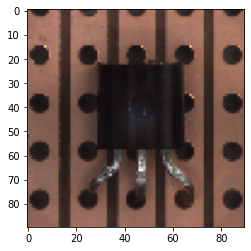

In [30]:
plt.imshow(x_train_ok[0])

In [31]:
# Building a Convolutional Neural Network using sequential model of Keras
def create_cnn_model():
    # MODEL_1
    model = keras.Sequential(
    [
        keras.Input(shape = INPUT_SIZE),     # Give Shape of each image as input to the model 
        keras.layers.BatchNormalization(),   # Apply batch normalization
        keras.layers.Conv2D(4, (3,3), activation = 'relu', kernel_regularizer=l2(2e-4), input_shape=INPUT_SIZE),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_regularizer=l2(2e-4)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_regularizer=l2(2e-4)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation = 'softmax'),
    ]
    ) 
    model.summary()
    
    return model

In [32]:
# Siamese Network
cnn_model = create_cnn_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90, 90, 3)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 88, 88, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 44, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 16)        2320  

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# If you determine labels with one-hot encoding, please use CategoricalCrossentropy loss, otherwise use SparseCategoricalCrossentropy
# from_logist: This attribute inform the loss function that the output values generated by the model are not 
# normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a 
# probability distribution. Therefore, the output layer in this case does not have a softmax activation function
# The softmax function would be automatically applied on the output values by the loss function. 
# Therefore, this does not make a difference with the scenario when you use from_logits=False (default) and a 
# softmax activation function on last layer; however, in some cases, this might help with numerical stability during
# training of the model. 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

cnn_model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])

In [34]:
cnn_model_history = cnn_model.fit(train_data,
                        epochs=NUM_EPOCH,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/100


2023-01-06 22:58:30.624271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-06 22:58:31.623947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


39/39 [==============================] - 2s 15ms/step - loss: 0.8975 - accuracy: 0.5518 - val_loss: 0.6719 - val_accuracy: 0.8529
Epoch 2/100
39/39 [==============================] - 0s 8ms/step - loss: 0.7156 - accuracy: 0.6269 - val_loss: 0.7053 - val_accuracy: 0.3971
Epoch 3/100
39/39 [==============================] - 0s 8ms/step - loss: 0.6133 - accuracy: 0.6653 - val_loss: 0.7747 - val_accuracy: 0.1176
Epoch 4/100
39/39 [==============================] - 0s 7ms/step - loss: 0.5317 - accuracy: 0.7396 - val_loss: 0.8347 - val_accuracy: 0.1176
Epoch 5/100
39/39 [==============================] - 0s 7ms/step - loss: 0.4566 - accuracy: 0.8016 - val_loss: 0.8836 - val_accuracy: 0.1324
Epoch 6/100
39/39 [==============================] - 0s 7ms/step - loss: 0.4028 - accuracy: 0.8343 - val_loss: 0.9354 - val_accuracy: 0.1618
Epoch 7/100
39/39 [==============================] - 0s 7ms/step - loss: 0.3738 - accuracy: 0.8612 - val_loss: 0.9886 - val_accuracy: 0.1618
Epoch 8/100
39/39 [=====

<AxesSubplot:>

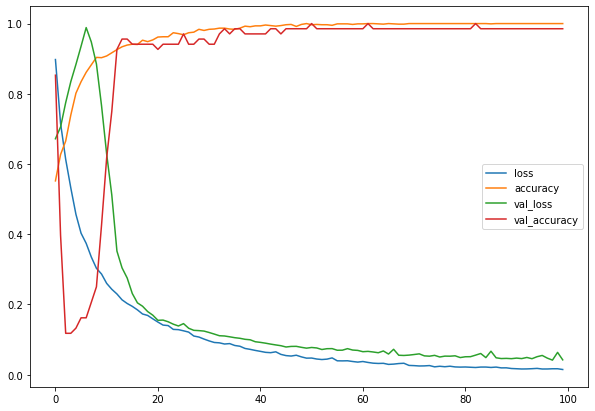

In [35]:
pd.DataFrame(cnn_model_history.history).plot(figsize=(10, 7))

In [36]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

3/3 - 0s - loss: 0.0420 - accuracy: 0.9853
Test Loss:  0.041988078504800797
Test Accuracy:  0.9852941036224365


In [37]:
y_pred_cnn = cnn_model.predict(x_test)

In [38]:
# Set prediction results for evaluation metrics
# Prepare Prediction List according to Output layer of the model

# Binary Classification
# predict = lambda ix: 1 if ix > 0.5 else 0

# Categorical Classification
predict = lambda arr: np.argmax(arr)

y_pred_abs = np.array(list(map(predict, y_pred_cnn)))  # Absolute value of prediction (If value greater than SIM_THRESHOD dissmilar, else similar)
y_pred_dis = np.copy(y_pred_cnn[:,1])
                

y_pred_cnn[:5]

array([[1.38783857e-01, 8.61216187e-01],
       [1.79668702e-03, 9.98203278e-01],
       [1.61322314e-04, 9.99838710e-01],
       [1.43506425e-08, 1.00000000e+00],
       [5.26694348e-04, 9.99473274e-01]], dtype=float32)

In [39]:
vision.print_eval_parameters(cnn_model, y_test, y_pred_abs, labels)

====== Functional model Evaluation metrics ======
Accuracy of model:      0.985
Recall of model:        0.985
Precision of model:     0.985
F1 score of model:      0.985
Misclassification Number:  1

====== Functional model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       1.00      0.88      0.93         8
 defect-free       0.98      1.00      0.99        60

    accuracy                           0.99        68
   macro avg       0.99      0.94      0.96        68
weighted avg       0.99      0.99      0.98        68



AUC:  1.0
No-skill AUC:  0.5



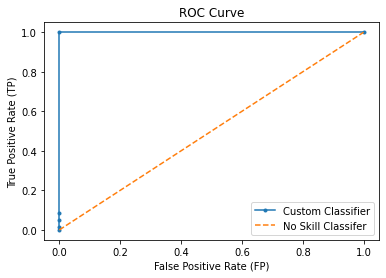

In [40]:
vision.show_ROC_score(y_test, y_pred_dis, plot=True)

AUC:  1.0



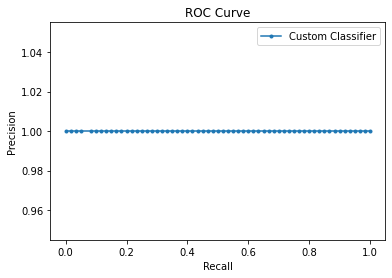

In [41]:
vision.show_ROC_score(y_test, y_pred_dis, kind='pre_rec', plot=True)

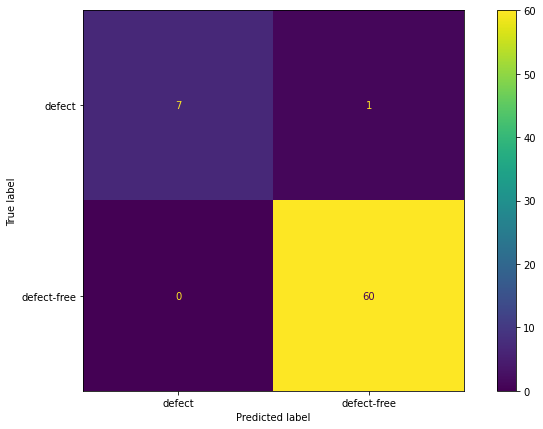

In [42]:
# vision.show_confusion_matrix(y_test_shuffled, y_pred_cnn, labels)
vision.show_confusion_matrix(y_test, y_pred_abs, labels)

### 